# Data Cleaning for Lead Exposure Project

In [242]:
# Packages to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rapidfuzz import process,fuzz

### Code to combine Service Line Inventory and Franklin County Parcel Data

In [253]:
# Import data files

# Documentation for the parcel data set is located at https://www.franklincountyauditor.com/AUDR-website/media/Documents/FTP/Parcel-CSV-description-of-fields.pdf
url_parcel = "https://apps.franklincountyauditor.com/Parcel_CSV/2025/05/Parcel.csv"
df_parcel = pd.read_csv(url_parcel)

# Service Line inventory data set
name_sl = "ServiceLineInventory.csv"
df_sl = pd.read_csv(name_sl)

/var/folders/2l/qpy8_v3d5x7glst5y2hhkz6m0000gn/T/ipykernel_26231/1256978046.py:5: DtypeWarning: Columns (12,13,14,15,31,33,54,59,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df_parcel = pd.read_csv(url_parcel)


In [256]:
# Create common Street Address column
df_sl["Street Address"] = df_sl["Street Number"].astype(str) + ' ' + df_sl["Street Name"]
#df_parcel = df_parcel.rename(columns={"STADDR":"Street Address"})

# Delete duplicate rows in each data set
df_parcel = df_parcel.drop_duplicates(subset=["STADDR"])
df_sl = df_sl.drop_duplicates(subset=["Street Address"])

In [ ]:
# Find number of matching addresses in both data sets

common_values = set(df_sl['Street Address']) & set(df_parcel['Street Address'])
num_matches = len(common_values)
num_sl = len(df_sl)
num_parcel = len(df_parcel)

percent_match = num_matches/num_sl*100
percent_nomatch = 100-percent_match

# Data frame with exact matches for addresses
df_match_exact = pd.merge(df_sl, df_parcel, left_on="Street Address", right_on="STADDR", how="inner")

print(f"Number of unique properties in parcel registry: {num_parcel}")
print(f"Number of unique properties listed in service line inventory: {num_sl}")
print(f"Number of unique matching addresses: {num_matches} ({percent_match:0.1f}%)")
print(f"Number of non-matching addresses: {num_sl-num_matches} ({percent_nomatch:0.1f}%)")


Number of unique properties in parcel registry: 424706
Number of unique properties listed in service line inventory: 283876
Number of unique matching addresses: 200470 (70.6%)
Number of non-matching addresses: 83406 (29.4%)


In [257]:
df_match_exact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200470 entries, 0 to 200469
Data columns (total 77 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   Street Number                                                 200470 non-null  object 
 1   Street Name                                                   200470 non-null  object 
 2   City                                                          200470 non-null  object 
 3   Zip Code                                                      200470 non-null  object 
 4   County                                                        200470 non-null  object 
 5   Latitude                                                      200470 non-null  float64
 6   Longitude                                                     200470 non-null  float64
 7   System-Owned Portion Service Line Material Classificatio

In [271]:
# Pull out all rows from Service Line Inventory without exact address matches
df_non_matches = df_sl[~df_sl["Street Address"].isin(df_parcel["STADDR"])]

# Consider a small sample of these rows
df_non_matches_sample = df_non_matches.sample(n=50)

def get_best_match(addr, choices, scorer=fuzz.token_sort_ratio):
    '''
    Use fuzzy logic package to match addresses. 
    addr: target address
    choices: range of possible addresses to match
    scorer: scoring method for fuzzy logic algorithm
    returns Pandas series containing the matched address and corresponding score
    '''

    results = process.extract(addr, choices, scorer=scorer,limit=5, score_cutoff=80)

    # If there are no results, return None
    if not results:
        return pd.Series([None, None])
    

     # See if address numbers are identical for any of the potential matches
    address_no = addr.split()[0]
    
    for match, score, _ in results:
        match_no = match.split()[0]
        if match_no == address_no:
            return pd.Series([match, score])
    
    # If no house number matches, return None
    return pd.Series([None, None])

        
## Get matches for sample dataset
"""
df_non_matches_sample[["Best Match", "Match Score"]] = df_non_matches_sample["Street Address"].apply(lambda addr: get_best_match(addr, df_parcel['STADDR']))
df_match_near = pd.merge(df_non_matches_sample, df_parcel, left_on="Best Match", right_on="STADDR", how="inner")
df_match_near = df_match_near.dropna(subset=['Best Match'])
"""

## Get matches for entire dataset
df_non_matches[["Best Match", "Match Score"]] = df_non_matches["Street Address"].apply(lambda addr: get_best_match(addr, df_parcel['STADDR']))
df_match_near = pd.merge(df_non_matches,df_parcel, left_on="Best Match", right_on="STADDR", how="inner")
df_match_near = df_match_near.dropna(subset=['Best Match'])

df_match_near.to_csv('data_match_near.csv')
#matches_fuzz = non_matches_sample_df.apply(lambda addr: process.extractOne(addr, df_parcel["STADDR"], scorer=fuzz.token_sort_ratio))

/var/folders/2l/qpy8_v3d5x7glst5y2hhkz6m0000gn/T/ipykernel_26231/530950355.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_matches[["Best Match", "Match Score"]] = df_non_matches["Street Address"].apply(lambda addr: get_best_match(addr, df_parcel['STADDR']))
/var/folders/2l/qpy8_v3d5x7glst5y2hhkz6m0000gn/T/ipykernel_26231/530950355.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_matches[["Best Match", "Match Score"]] = df_non_matches["Street Address"].apply(lambda addr: get_best_matc

In [272]:
df_match_near.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37075 entries, 1 to 83391
Data columns (total 80 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Street Number                                                 37075 non-null  object 
 1   Street Name                                                   37075 non-null  object 
 2   City                                                          37075 non-null  object 
 3   Zip Code                                                      37075 non-null  object 
 4   County                                                        37075 non-null  object 
 5   Latitude                                                      37075 non-null  float64
 6   Longitude                                                     37075 non-null  float64
 7   System-Owned Portion Service Line Material Classification     37075 non-

In [ ]:
# Now 

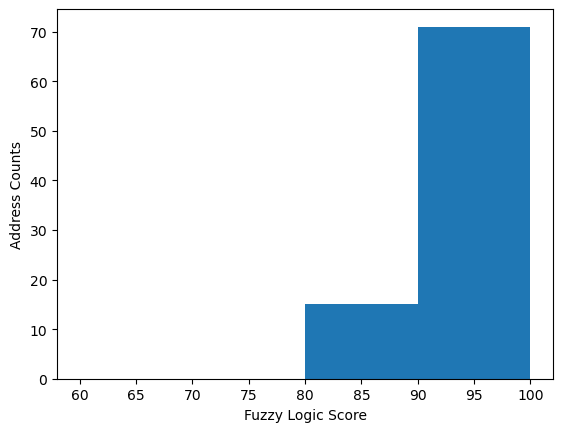

In [203]:
plt.hist(non_matches_sample_df["Match Score"], bins=np.arange(60,105,10))
plt.xlabel('Fuzzy Logic Score')
plt.ylabel('Address Counts')
plt.show()

In [144]:
# Extract matched addresses and scores
non_matches_sample_df["best_match"] = [m[0] if m else None for m in matches_fuzz]
non_matches_sample_df["match_score"] = [m[1] if m else 0 for m in matches_fuzz]

#non_matches_sample_df = pd.DataFrame(non_matches_sample_df)



print(f'Mean score: {np.mean(non_matches_sample_df["match_score"])}')
print(f'Median Score: {np.median(non_matches_sample_df["match_score"])}')
print(f'Minimum Score: {np.min(non_matches_sample_df["match_score"])}')
print(f'Score Standard Deviation: {np.std(non_matches_sample_df["match_score"])}')

Mean score: 89.2850103437884
Median Score: 92.85714285714286
Minimum Score: 64.51612903225806
Score Standard Deviation: 7.667967192648201


In [146]:
non_matches_sample_df.info()

<class 'pandas.core.series.Series'>
Index: 102 entries, 159887 to match_score
Series name: Street Address
Non-Null Count  Dtype 
--------------  ----- 
102 non-null    object
dtypes: object(1)
memory usage: 5.7+ KB


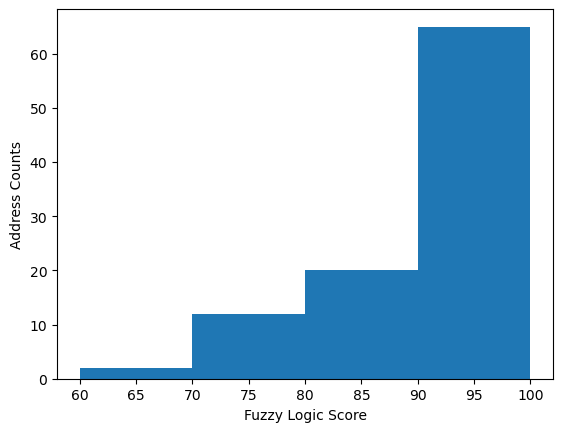

In [140]:
plt.hist(non_matches_sample_df["match_score"], bins=np.arange(60,105,10))
plt.xlabel('Fuzzy Logic Score')
plt.ylabel('Address Counts')
plt.show()

In [ ]:
non_matches_sample_df = pd.DataFrame(non_matches_sample_df)


In [129]:
non_matches_sample_df["match_score"]
filtered_non_matches_df = non_matches_sample_df[non_matches_sample_df["match_score"].between(60,70)]
filtered_non_matches_df

AttributeError: 'list' object has no attribute 'between'

In [100]:
matches_fuzz_array = np.array(matches_fuzz)

matches_fuzz_array

array([('2212 HARRISBURG PK', 91.89189189189189, 312544),
       ('700 N HIGH ST', 72.72727272727273, 298627),
       ('7580 N COVENTRY WOODS DR', 95.65217391304348, 372364),
       ('7100 SCRIBNER WY', 96.96969696969697, 369025),
       ('7702 SOLOMEN RUN DR', 94.73684210526316, 389551),
       ('2635 HENTHORN RD', 96.96969696969697, 268274),
       ('1900 KENNY RD', 78.78787878787878, 141526),
       ('2633 RUSTLING OAK BL', 81.63265306122449, 417112),
       ('1380 E KNOLLWOOD DR', 100.0, 118810),
       ('916 MEADOW DOWNS TL', 94.73684210526316, 160183),
       ('E 11TH AVE', 80.0, 22501),
       ('185 N HAGUE AVE', 96.7741935483871, 53144),
       ('672 E MITHOFF ST', 96.7741935483871, 23593),
       ('2076 BROOKHURST AVE', 94.73684210526316, 129721),
       ('3229 SCIOTO BLUFF AVE', 82.92682926829268, 347889),
       ('7525 SANCUS BL', 93.33333333333333, 478062),
       ('2846 KEYSTONE DR', 78.78787878787878, 107755),
       ('6801 VILLAGE PW', 81.25, 376040),
       ('2856 ROBIN

In [51]:
df_parcel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424706 entries, 0 to 483863
Data columns (total 68 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   PARCEL ID        424706 non-null  object 
 1   AEXMLND          424706 non-null  float64
 2   AEXMBLD          424706 non-null  float64
 3   AEXMTOT          424706 non-null  float64
 4   APPRLND          424706 non-null  float64
 5   APPRBLD          424706 non-null  float64
 6   APPRTOT          424706 non-null  float64
 7   AUDMAP           423568 non-null  object 
 8   AUDRTG           423568 non-null  float64
 9   LANDUSE          418691 non-null  float64
 10  CAUV             411109 non-null  float64
 11  SCHOOL           424706 non-null  int64  
 12  MAILAD1          419632 non-null  object 
 13  MAILAD2          83552 non-null   object 
 14  MAILAD3          419442 non-null  object 
 15  MAILAD4          419441 non-null  object 
 16  TRANDT           423997 non-null  object 
 

In [52]:
df_sl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283876 entries, 0 to 288459
Data columns (total 11 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   Street Number                                                 283858 non-null  object 
 1   Street Name                                                   283876 non-null  object 
 2   City                                                          283876 non-null  object 
 3   Zip Code                                                      283876 non-null  object 
 4   County                                                        283876 non-null  object 
 5   Latitude                                                      283876 non-null  float64
 6   Longitude                                                     283876 non-null  float64
 7   System-Owned Portion Service Line Material Classification    

In [ ]:
df_sl.sample(n=10, random_state=43201)

,Street Number,Street Name,City,Zip Code,County,Latitude,Longitude,System-Owned Portion Service Line Material Classification,If Non-Lead in Column R.. Was Material Ever Previously Lead?,Customer-Owned Portion Service Line Material Classification
34732,5030,BLACKSTONE EDGE DR,NEW ALBANY,43054-7902,FRANKLIN,40.087862,-82.806111,PL,N,OT
164514,4178,MARATHON CT,GAHANNA,43230-1108,FRANKLIN,40.071140,-82.909087,PL,N,OT
208164,1015,RACINE AVE,COLUMBUS,43204-2720,FRANKLIN,39.933923,-83.073469,CU,N,MU
266767,300,W GRANVILLE RD,WORTHINGTON,43085-3527,FRANKLIN,40.089909,-83.025227,OT,N,OT
260335,6080,TURKEY LEGS CT,DUBLIN,43017-3590,FRANKLIN,40.079629,-83.095792,PL,N,OT
254530,6437,TEAPOT LN,REYNOLDSBURG,43068-3956,FRANKLIN,39.924004,-82.827869,OT,N,PL
76849,4960,DUBLIN RD,DUBLIN,43017-4316,FRANKLIN,40.068597,-83.112293,CU,N,OT
230795,5096,SAND CT,GROVEPORT,43125-9394,FRANKLIN,39.869658,-82.868624,PL,N,OT
163542,1169,MANOR DR,COLUMBUS,43232-1640,FRANKLIN,39.953371,-82.833224,OT,N,OT
431,639,AUGUSTA AVE,COLUMBUS,43228-2901,FRANKLIN,39.939754,-83.110214,CU,Y,GAL


In [44]:
df_sl["Street Address"]

0                  39 13TH
1            1305 19TH AVE
2            1327 19TH AVE
3            1376 19TH AVE
4            1320 19TH AVE
                ...       
288457    6255 ZUMSTEIN DR
288458    6255 ZUMSTEIN DR
288459    6325 ZUMSTEIN DR
288460    6125 ZUMSTEIN DR
288461    6325 ZUMSTEIN DR
Name: Street Address, Length: 288462, dtype: object

In [48]:
df_sl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288462 entries, 0 to 288461
Data columns (total 11 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   Street Number                                                 288387 non-null  object 
 1   Street Name                                                   288462 non-null  object 
 2   City                                                          288462 non-null  object 
 3   Zip Code                                                      288462 non-null  object 
 4   County                                                        288462 non-null  object 
 5   Latitude                                                      288462 non-null  float64
 6   Longitude                                                     288462 non-null  float64
 7   System-Owned Portion Service Line Material Classificatio

In [40]:
df_parcel["STADDR"].split(' ',1)

AttributeError: 'Series' object has no attribute 'split'

In [35]:
df_parcel[["STHNUM", "STDIRE", "STNAME", "STADDR", "USPS_CITY", "ZIPCODE"]].sample(n=5)

,STHNUM,STDIRE,STNAME,STADDR,USPS_CITY,ZIPCODE
33269,39.0,E,PATTERSON,39 E PATTERSON AVE,COLUMBUS,43202.0
200529,227.0,NaN,HEATHERBRIDGE,227 HEATHERBRIDGE LN,BLACKLICK,43004.0
138051,1094.0,S,MERRIMAR,1094 S MERRIMAR CR,COLUMBUS,43220.0
427297,2511.0,NaN,WILLOW PARK,2511 WILLOW PARK RD,GROVE CITY,43123.0
226597,882.0,NaN,BURR,882 BURR AVE,COLUMBUS,43212.0


In [39]:
df_parcel = df_parcel.astype({'PCLASS':'str', 
                              'STHNUM':'int',
                              'STDIRE':'str',
                              'STNAME':'str',
                              'GRADE':'str', 
                              'POINT_Y':'float64'})
df_parcel["street name new"].sample(n=10)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer: Error while type casting for column 'STHNUM'

In [33]:
df_parcel["USPS_CITY"].sample(n=10)

177191      COLUMBUS
196416    NEW ALBANY
416288      HILLIARD
319022      COLUMBUS
419820      HILLIARD
438496      COLUMBUS
271459      COLUMBUS
462002      COLUMBUS
297426      COLUMBUS
12333       COLUMBUS
Name: USPS_CITY, dtype: object

In [32]:
columns_address = ["STHNUM", "STCONT", "STHSFX", "STDIRE", "STNAME", "STSFX", "STADDR"]
df_address = df_parcel[columns_address]

In [ ]:
columns_to_keep = ['PARCEL ID', 'APPRTOT', 'PRICE', 'PCLASS', 'GRADE', 'YEARBLT', 'POINT_X', 'POINT_Y']
#df_parcel_short = df_parcel[]

In [28]:
df

,PARCEL ID,AEXMLND,AEXMBLD,AEXMTOT,APPRLND,APPRBLD,APPRTOT,AUDMAP,AUDRTG,LANDUSE,...,NOSTORY,YEARBLT,PROPTYP,WALL,TIFMLND,TIFMBLD,POINT_X,POINT_Y,HOMSTD,BANKCODE
0,010-000001,0.0,0.0,0.0,11300.0,73300.0,84600.0,H001,71.0,520.0,...,20.0,1900.0,NaN,STUCCO,203700.0,118700.0,1.828201e+06,721773.867345,NaN,NaN
1,010-000002,0.0,0.0,0.0,121800.0,160000.0,281800.0,R044,94.0,510.0,...,15.0,1910.0,NaN,WD/ALUM/VINYL,0.0,0.0,1.823726e+06,738685.399302,NaN,NaN
2,010-000003,0.0,0.0,0.0,37800.0,4500.0,42300.0,K037,191.0,399.0,...,NaN,NaN,NaN,NaN,0.0,0.0,1.835470e+06,705365.735381,NaN,NaN
3,010-000004,0.0,297900.0,297900.0,114900.0,0.0,114900.0,I017,80.0,510.0,...,20.0,2017.0,NaN,WD/ALUM/VINYL,0.0,0.0,1.840164e+06,714787.198657,NaN,NaN
4,010-000005,0.0,0.0,0.0,100000.0,403200.0,503200.0,N047,172.0,401.0,...,NaN,NaN,NaN,NaN,0.0,0.0,1.813787e+06,725871.027785,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483882,610-341317,0.0,0.0,0.0,0.0,0.0,0.0,T106J,92.0,NaN,...,10.0,2016.0,NaN,WD/ALUM/VINYL,0.0,0.0,1.826366e+06,771805.490542,NaN,NaN
483883,610-341318,0.0,0.0,0.0,0.0,0.0,0.0,T106J,93.0,NaN,...,10.0,2016.0,NaN,WD/ALUM/VINYL,0.0,0.0,1.826366e+06,771805.490542,NaN,NaN
483884,610-341319,0.0,0.0,0.0,0.0,0.0,0.0,T106J,94.0,NaN,...,10.0,2016.0,NaN,WD/ALUM/VINYL,0.0,0.0,1.826366e+06,771805.490542,NaN,NaN
483885,610-341320,0.0,0.0,0.0,0.0,0.0,0.0,T106J,95.0,NaN,...,10.0,2016.0,NaN,3/6 MASONRY TO FRAME .500,0.0,0.0,1.826366e+06,771805.490542,NaN,NaN


In [28]:
df["PCLASS"].head()

columns_to_keep = ['PARCEL ID', 'APPRTOT', 'PRICE', 'PCLASS', 'GRADE', 'YEARBLT', 'POINT_X', 'POINT_Y']

df_column_filtered = df[columns_to_keep]

df_column_filtered.info()

NameError: name 'df' is not defined

In [60]:
df_column_filtered['POINT_Y'].head()

0    721773.867345
1    738685.399302
2    705365.735381
3    714787.198657
4    725871.027785
Name: POINT_Y, dtype: object

In [64]:
df_column_filtered = df_column_filtered.astype({'PCLASS':'str', 'GRADE':'str', 'POINT_Y':'float64'})

ValueError: could not convert string to float: 'Y': Error while type casting for column 'POINT_Y'

In [56]:
df_filtered = df_column_filtered[df_column_filtered['PCLASS'].isin(['R'])]

In [57]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 422709 entries, 0 to 483886
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   PARCEL ID  422709 non-null  object 
 1   APPRTOT    422709 non-null  float64
 2   PRICE      422066 non-null  float64
 3   PCLASS     422709 non-null  object 
 4   GRADE      401208 non-null  object 
 5   YEARBLT    401194 non-null  float64
 6   POINT_X    422709 non-null  float64
 7   POINT_Y    422684 non-null  object 
dtypes: float64(4), object(4)
memory usage: 29.0+ MB
